In [83]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from ipynb.fs.defs.image_shuffler import make_image

In [59]:
# --- image functions ---

# read image as numpy array
def read_image(filename):
    return np.array(Image.open(filename))

# print image
def show_image(image):
    plt.imshow(image)
    plt.show()

# save image
def write_image(image, filename):
    Image.fromarray(image).save(filename)

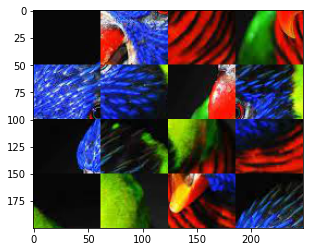

In [60]:
# reading shuffled image
# NOTE: if the image is not already shuffled then it can be done using the utility file 'image_shuffler.py'
image = read_image("shuffled_image.png")
show_image(image)


In [61]:
# function to calculate the left right border cost
def border_cost(s1, s2):
    r_col = s1[:, -1, :].astype(np.int16)
    l_col = s2[:, 0, :].astype(np.int16)
    diff_col = np.absolute(np.subtract(r_col, l_col))
    
    return np.sum(diff_col)

# function to find columns
def find_columns(image, threshold):
    idx = []
    costs = []

    for i in range(image.shape[1] - 1):
        right = image[:, i + 1: i + 2, :]
        left = image[:, i: i + 1, :]
        __c = border_cost(left, right)
        costs.append(__c)

    for i, c in enumerate(costs):
        if c > threshold:   # if the cost is greater than the threshold then the column is not a part of the solution
            idx.append(i)

    # plot the costs
    cplot(costs, threshold)

    if len(idx) == 0:
        return 1

    if len(idx) == 1:
        w = min(image.shape[1] - idx[0], idx[0])
        result = round(image.shape[1] / w)
        return result

    gaps = [idx[i + 1] - idx[i] for i in range(len(idx) - 1)]
    w = LCD(gaps)
    result = int(image.shape[1] / w)
    return result

# function to find rows


def find_rows(image, threshold):
    copy_image = np.copy(image)
    rot_image = np.copy(np.rot90(copy_image))
    return find_columns(rot_image, threshold)

# function to plot the costs


def cplot(costs, threshold):
    fig = plt.figure(figsize=(5, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.axhline(y=threshold)
    plt.scatter(list(range(len(costs))), costs)
    plt.grid()
    plt.savefig("costs.png")


# function to find the least common divisor
def LCD(l):
    mini = min(l)
    assert mini > 0
    for i in range(mini, 0, -1):
        rests = [e % i for e in l]
        if not any(rests):
            return i


# function to find the first piece of the puzzle from cost matrix
def fp_finder(left_right_costs_matrix, ud_costs_matrix):
    # which one to go at the top-left corner
    left_right_scores = np.min(left_right_costs_matrix, axis=0)
    ud_scores = np.min(ud_costs_matrix, axis=0)
    tot_scores = left_right_scores + ud_scores
    id_top_right_corner = np.argmax(tot_scores)
    return id_top_right_corner


In [80]:
class Jigsaw:
    def __init__(self, left_right_costs_matrix, up_down_costs_matrix, n_cols, n_rows, first_piece):
        self.left_right_cost_matrix = np.copy(left_right_costs_matrix)
        self.up_down_cost_matrix = np.copy(up_down_costs_matrix)
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.first_piece = first_piece
        self.used_ids = []
        self.res_in_levels = []

    def get_idx(self, level, row):
        assert level >= row
        col = level - row
        idx = row * self.n_cols + col
        return idx

    def get_idx_parents(self, level, row):
        # parents have level-1
        # parent_l has col-1 and same row
        # parent_t has same col and row-1
        if level == 0:
            return None, None
        parents_level = level - 1
        if row == level:  # child is on left-most column
            return None, self.get_idx(parents_level, row-1)
        if row == 0:  # child is on top-most column
            return self.get_idx(parents_level, 0), None
        parent_l_row = row
        parent_t_row = row - 1
        parent_l = self.get_idx(parents_level, parent_l_row)
        parent_t = self.get_idx(parents_level, parent_t_row)
        return parent_l, parent_t

    def find_best(self, parent_l, parent_t):
        r_candidates = self.left_right_cost_matrix[parent_l,
                                                   :] if parent_l is not None else 0
        d_candidates = self.up_down_cost_matrix[parent_t,
                                                :] if parent_t is not None else 0
        total_candidates = r_candidates + d_candidates
        found = False
        while not found:
            if np.min(total_candidates) == np.inf:
                print("ERROR: no piece found after self.res_in_levels = [{}]".format(
                    self.res_in_levels))
                return None
            best = np.argmin(total_candidates)
            if best in self.used_ids:
                print("ISSUE: want to add {} a second time as child of parent_l = {} and parent_t = {}".format(
                    best, parent_l, parent_t))
                total_candidates[best] = np.inf
            else:
                found = True
                self.used_ids.append(best)
        return best

    def format_res_levels(self, res_in_levels):
        res = np.zeros((self.n_rows, self.n_cols))
        for row in range(self.n_rows):
            for col in range(self.n_cols):
                level = row + col
                res[row, col] = res_in_levels[level][row]
        print("res_in_levels = {}".format(res_in_levels))
        print("format_levels = {}".format(res))
        return res.astype(np.int16)

    def get_id_in_res(self, position_in_flat_list, res_in_levels):
        row = position_in_flat_list // self.n_cols
        col = position_in_flat_list % self.n_cols
        level = row + col
        piece_at_position = res_in_levels[level][row]
        return piece_at_position

    def solve(self):
        # first piece cannot be a right-neighbour
        self.left_right_cost_matrix[:, self.first_piece] = np.inf
        # first piece cannot be a down-neighbour
        self.up_down_cost_matrix[:, self.first_piece] = np.inf
        self.used_ids.append(self.first_piece)
        self.res_in_levels = [[self.first_piece]]  # alone in level=0

        for level in range(1, self.n_cols + self.n_rows - 1):
            list_for_level = []
            # no need to explore row > n_rows
            for row_id in range(min(self.n_rows, level+1)):
                if level + 1 - row_id > self.n_cols:
                    list_for_level.append(None)
                else:
                    # position of the parents in the 0, 1, 2 ... coordinate system
                    parent_l_out, parent_t_out = self.get_idx_parents(
                        level, row_id)
                    parent_l_in = self.get_id_in_res(
                        parent_l_out, self.res_in_levels) if parent_l_out is not None else None
                    parent_t_in = self.get_id_in_res(
                        parent_t_out, self.res_in_levels) if parent_t_out is not None else None
                    best = self.find_best(parent_l_in, parent_t_in)
                    list_for_level.append(best)
            self.res_in_levels.append(list_for_level)
        res = self.format_res_levels(self.res_in_levels)
        return res


4 = n_cols
62 = col_width


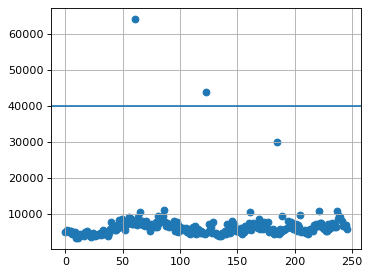

In [63]:
# step.1: find number of columns and rows

# no of columns and width of the puzzle
n_cols = find_columns(image, threshold=40000)
w = int(image.shape[1] / n_cols)
print("{} = n_cols".format(n_cols))
print("{} = col_width".format(w))

1 = n_rows
200 = row_height


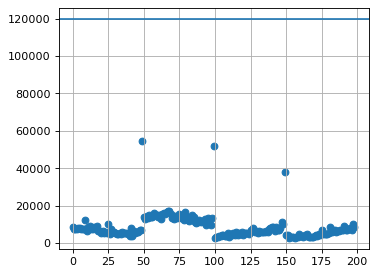

In [64]:
# no of rows and height of the puzzle
n_rows = find_rows(image, threshold=120000)
h = int(image.shape[0] / n_rows)
print("{} = n_rows".format(n_rows))
print("{} = row_height".format(h))

In [70]:
# step.2: extracing the puzzle pieces

rows = [image[i * h: (i + 1) * h, :, :] for i in range(n_rows)]
print("length of rows: {}".format(len(rows)))

parts = []
for i in rows:
    for idx in range(n_cols):
        parts.append(i[:, idx * w: (idx + 1) * w, :])

print("length of image pieces: {}".format(len(parts)))
parts[0].shape, parts[-1].shape

length of rows: 1
length of image pieces: 4


((200, 62, 3), (200, 62, 3))

In [72]:
#  step.3: finding best order

n = n_cols * n_rows
left_right_cost_matrix = np.zeros((n, n))
up_down_cost_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        left_right_cost_matrix[i, j] = np.inf if i == j else border_cost(parts[i], parts[j])
        up_down_cost_matrix[i, j] = np.inf if i == j else border_cost(parts[i].T, parts[j].T)

left_right_cost_matrix, up_down_cost_matrix

(array([[   inf, 64229., 44017., 20256.],
        [41877.,    inf, 43792., 31997.],
        [30759., 60094.,    inf, 30019.],
        [47075., 62180., 47890.,    inf]]),
 array([[   inf, 64229., 44017., 20256.],
        [41877.,    inf, 43792., 31997.],
        [30759., 60094.,    inf, 30019.],
        [47075., 62180., 47890.,    inf]]))

first piece = 1


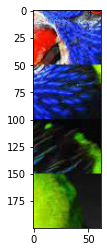

In [86]:
# step.4: find first piece

fp = fp_finder(left_right_cost_matrix, up_down_cost_matrix)
print("first piece = {}".format(fp))
show_image(parts[fp])

In [81]:
# step.5: solve the puzzle starting assembling from the first piece

__solve = Jigsaw(left_right_cost_matrix, up_down_cost_matrix, n_cols, n_rows, fp)

In [82]:
order = __solve.solve()
order

ISSUE: want to add 3 a second time as child of parent_l = 0 and parent_t = None
res_in_levels = [[1], [3], [0], [2]]
format_levels = [[1. 3. 0. 2.]]


array([[1, 3, 0, 2]], dtype=int16)

In [85]:
# step.6: recontruct the image using the good order devised in the previous step
image2 = make_image(parts, order)

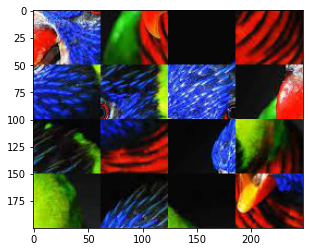

In [87]:
show_image(image2)